# Import infection rate from .csv file, plot and fit

## Data source (hmudata.org):

## https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import date

In [2]:
# load csv file and save number of infections
Infections = []
with open('time_series_covid19_confirmed_global.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    # skip first row with column headings
    for row in csv_reader:
        
        if line_count == 156:
            Infections = row[4:]
        line_count += 1

Infections = np.asarray(Infections,dtype = 'float')
print('Total infections so far: ' + str(Infections[-1]) )

Total infections so far: 156.0


In [4]:
# Models (fit functions)

def simple_expo(x,a,b,c):
    return a * np.exp(-b * x) + c

def linear_expo(x,m,a,b,c):
    return (m*x + a*np.exp(-b*x) + c)

def logistic(x,K,P0,r):
    return K/(1+((K-P0)/P0)*np.exp(-r*x))

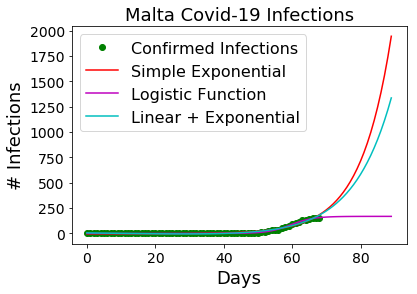

In [5]:
Days = np.arange(0,len(Infections),1)
Days_long = np.arange(0,len(Infections)+21)
FS = 18
plt.plot(Days,Infections,'o',color = 'green', markersize = 6,label = 'Confirmed Infections')
plt.ylabel('# Infections',fontsize = FS)
plt.xlabel('Days',fontsize = FS)
plt.title('Malta Covid-19 Infections', fontsize = FS)

# fit functions
p_lin, pc_lin = curve_fit(simple_expo, Days, Infections,p0 = (0.3,-0.5,5))


weight_fac = 4
weight_fn = np.arange(weight_fac, 1, -(weight_fac-1) /len(Infections))

p_lin_w, pc_lin_w = curve_fit(simple_expo, Days, Infections,p0 = (0,-0.5,5),\
                          sigma = weight_fn, bounds = ([-10,-10.,0],[10.,10.,6]))

p_linexp, pc_linexp = curve_fit(linear_expo, Days, Infections,p0 = (1,0,-0.5,5))


p_log, pc_log = curve_fit(logistic, Days, Infections,p0 = (1000,1,0.23),maxfev=5000\
                         ,bounds = ([150,0,0],[np.inf,30,np.inf]))

#plt.plot(Days,simple)
plt.plot(Days_long, simple_expo(Days_long, *p_lin), 'r-',label = 'Simple Exponential')
#plt.plot(Days_long, simple_expo(Days_long, *p_lin_w), 'b-',label = 'Weighted Exponential')
#plt.plot(Days_long, simple_expo(Days_long, *p_log), 'm-',label = 'Logistic fn.')
plt.plot(Days_long, logistic(Days_long, *p_log), 'm-',label = 'Logistic Function')
plt.plot(Days_long, linear_expo(Days_long, *p_linexp), 'c-',label = 'Linear + Exponential')


plt.legend(fontsize = FS-2)
plt.xticks(fontsize = FS-4)
plt.yticks(fontsize = FS-4);


In [6]:
def next_day_predict(fn,params,cov,Day_1):
    pred = np.round(fn(Day_1,*params))
    day_before = np.round(fn(Day_1-1,*params))
    pred_up = np.round(fn(Day_1,*(params-np.sqrt(np.diag(cov)))))
    return str(pred-day_before) + '+/-' + str(np.abs(pred_up-pred))

print('Simple next day new cases: ' + \
      next_day_predict(simple_expo,p_lin,pc_lin,Days[-1]+1))

print('Recent-weighted next day new cases: ' + \
      next_day_predict(simple_expo,p_lin_w,pc_lin_w,Days[-1]+1))

print('Linear + Expo. next day new cases: ' + \
      next_day_predict(linear_expo,p_linexp,pc_linexp,Days[-1]+1))

print('Logisitic next day new cases: ' + \
      next_day_predict(logistic,p_log,pc_log,Days[-1]+1))

print('')

print('Simple doubling time (days): ' + str(np.round(-np.log(2)/p_lin[1],2)))
print('Weighted doubling time (days): ' + str(np.round(-np.log(2)/p_lin_w[1],2)))
print('Logisitic doubling time (days): ' + str(np.round(np.log(2)/p_log[2],2)))

print('')

# peak infections uncertainty is very high...
print('Peak infections: ' + str(np.round(p_log[0])) + '+/-' \
      + str(np.round(-p_log[0]+np.sqrt(pc_log[0,0]))))

Simple next day new cases: 23.0+/-18.0
Recent-weighted next day new cases: 140.0+/-7739602.0
Linear + Expo. next day new cases: 20.0+/-64.0
Logisitic next day new cases: 3.0+/-11.0

Simple doubling time (days): 6.24
Weighted doubling time (days): 1.39
Logisitic doubling time (days): 2.29

Peak infections: 168.0+/--167.0


In [11]:
# residuals

def msq (Data,model):
    return (np.mean((Data-model)**2))

print(msq(Infections,simple_expo(Days, *p_lin)))
print(msq(Infections,simple_expo(Days, *p_lin_w)))
print(msq(Infections,linear_expo(Days, *p_linexp)))
print(msq(Infections,logistic(Days, *p_log)))



73.83121778572075
1100.6495700034711
56.82482367252163
2.317067361066246


Text(0.5, 1.0, 'Malta Covid-19 Infection Projection: Mar 31 2020')

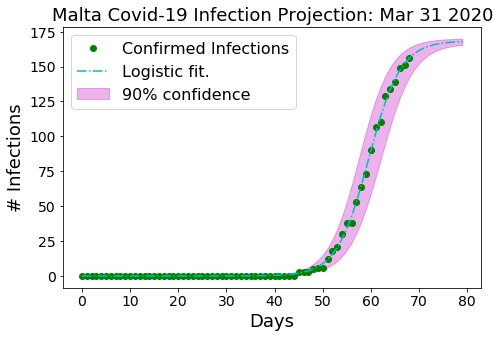

In [8]:
#logistic fit range of outcomes
Days_longer = np.arange(0,80)
y0 = logistic(Days_longer, *p_log)
y_up = logistic(Days_longer, *(p_log-np.sqrt(np.diag(pc_log))))
y_do = logistic(Days_longer, *(p_log+np.sqrt(np.diag(pc_log))))

plt.rcParams["figure.figsize"] = [7.5, 4.8]
fig, ax1 = plt.subplots()
ax1.fill_between(Days_longer, y_do, y_up,color = 'm', alpha = 0.3, label = '90% confidence')

plt.plot(Days,Infections,'o',color = 'green', markersize = 6,label = 'Confirmed Infections')
plt.plot(Days_longer, logistic(Days_longer, *p_log), 'c-.',label = 'Logistic fit.')

plt.xticks(fontsize = FS-4)
plt.yticks(fontsize = FS-4)
plt.legend(fontsize = FS-2, loc = 'upper left')
plt.ylabel('# Infections',fontsize = FS)
plt.xlabel('Days',fontsize = FS)
plt.title('Malta Covid-19 Infection Projection: ' \
          + (date.today()).strftime("%b %d %Y"), fontsize = FS)

Text(0.5, 0, 'Day')

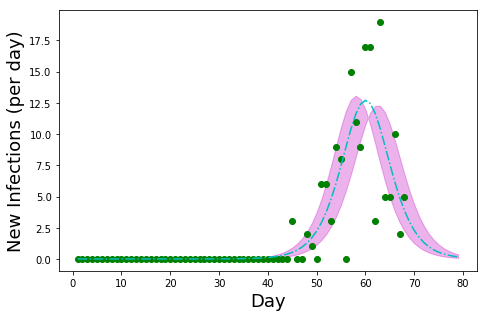

In [9]:
y0 = np.diff(logistic(Days_longer, *p_log),axis = 0)
y_up = np.diff(logistic(Days_longer, *(p_log-np.sqrt(np.diag(pc_log)))),axis = 0)
y_do = np.diff(logistic(Days_longer, *(p_log+np.sqrt(np.diag(pc_log)))),axis = 0)

plt.rcParams["figure.figsize"] = [7.5, 4.8]
fig, ax1 = plt.subplots()
ax1.fill_between(Days_longer[1:], y_do, y_up,color = 'm', alpha = 0.3, \
                 label = '90% confidence')
plt.plot(Days[1:],np.diff(Infections,axis=0),'og')
plt.plot(Days_longer[1:],y0,'c-.')

plt.ylabel('New Infections (per day)',fontsize = FS)
plt.xlabel('Day',fontsize = FS)